"Predicted Tracking Error Rebalance Portfolio"（预测跟踪误差再平衡投资组合）是一个高级的投资管理概念，主要用于量化投资策略中。这个概念结合了两个关键部分：预测跟踪误差（Predicted Tracking Error）和投资组合再平衡（Portfolio Rebalance）。下面我将为您逐一解释这些术语，并说明它们是如何结合在一起的。

### 预测跟踪误差（Predicted Tracking Error）

跟踪误差是指一个投资组合的表现与其基准（benchmark）之间的偏差。在量化投资中，管理者经常尝试通过复制一个指数或基准来最小化这种偏差，以此来确保投资组合的表现与市场或特定基准保持一致。预测跟踪误差则是对未来某段时间内投资组合相对于其基准可能出现的偏差的预测。这种预测通常基于历史数据、市场波动性和投资组合持有的特定资产。

### 投资组合再平衡（Portfolio Rebalance）

投资组合再平衡是指根据投资者的目标、风险偏好和市场条件调整投资组合中各种资产类别的比例。随着市场变动，原定的资产分配比例会发生改变，可能导致投资组合承担更高或更低的风险，或偏离预定的投资目标。通过定期或根据特定条件再平衡，可以确保投资组合保持与投资者目标一致。

### 结合应用

将"预测跟踪误差"与"投资组合再平衡"结合，意味着使用预测跟踪误差作为再平衡投资组合的依据之一。具体来说，如果预测的跟踪误差超出了事先设定的容忍范围，那么就需要进行投资组合再平衡。这种方法有助于投资者主动管理风险，尤其是在追求与特定基准保持一致性的策略中。

通过监控预测的跟踪误差，并在其达到特定阈值时调整投资组合持仓，可以帮助投资者更加精细地控制与基准之间的偏差，同时优化潜在回报。这种策略特别适用于被动管理的指数基金和ETFs，以及那些旨在紧密跟踪特定市场表现的主动管理基金。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt

%matplotlib inline

In [35]:
import dtale

# Create Fake Index Data

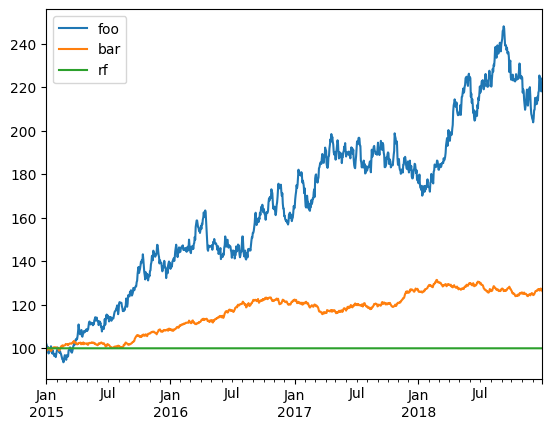

In [2]:
names = ['foo','bar','rf']
# 使用pandas.date_range函数生成从2015年1月1日到2018年12月31日之间的工作日日期序列。
# pd.tseries.offsets.BDay()表示只包括工作日（排除周末和公共假日）。
dates = pd.date_range(start='2015-01-01',end='2018-12-31', freq=pd.tseries.offsets.BDay())
n = len(dates)

rdf = pd.DataFrame(
    np.zeros((n, len(names))),
    index = dates,
    columns = names
)

np.random.seed(1)
# 为foo和bar列生成正态分布的随机数，模拟每日收益率。其中，loc参数表示均值，scale参数表示标准差，size=n表示生成数量与日期数量相同。
# foo列模拟的是一个平均年化收益率为10%、年化波动率为20%的资产。
# bar列模拟的是一个平均年化收益率为4%、年化波动率为5%的资产。
# 这里的均值和标准差都通过除以252（一年中的交易日数量）进行了调整，以反映每日收益率。
rdf['foo'] = np.random.normal(loc = 0.1/252,scale=0.2/np.sqrt(252),size=n)
rdf['bar'] = np.random.normal(loc = 0.04/252,scale=0.05/np.sqrt(252),size=n)
# 将无风险收益率（rf）列设置为0，假设无风险资产每日收益率为0。
rdf['rf'] = 0.

# 计算每个资产从初始投资100单位货币开始的累积收益率。np.cumprod(1+rdf)计算累积乘积，即每一天的价值是前一天价值乘以(1+当天收益率)
pdf = 100*np.cumprod(1+rdf)
pdf.plot();

In [5]:
pdf

,foo,bar,rf
2015-01-01,102.086165,100.050305,100.0
2015-01-02,101.339856,99.579502,100.0
2015-01-05,100.705721,99.110236,100.0
2015-01-06,99.384330,99.309091,100.0
2015-01-07,100.507366,99.692444,100.0
...,...,...,...
2018-12-25,223.595248,127.040703,100.0
2018-12-26,224.094283,127.454858,100.0
2018-12-27,218.025463,126.837968,100.0
2018-12-28,219.766321,126.838740,100.0


# Build and run Target Strategy
I will first run a strategy that rebalances everyday.

Then I will use those weights as target to rebalance to whenever the PTE is too high.

In [4]:
# 这行代码创建了一个算法对象，用于在后续的策略中只选择foo和bar两个资产进行操作。这意味着，无论原始数据中有多少资产，策略只会考虑这两个。
selectTheseAlgo = bt.algos.SelectThese(['foo','bar'])

# algo to set the weights to 1/vol contributions from each asset
#  with data over the last 3 months excluding yesterday
# 这个算法用于根据过去三个月（排除昨天）的数据计算资产的逆波动率权重。
# 逆波动率加权是一种资产配置方法，旨在通过分配更多的权重给历史波动率较低的资产来降低组合的整体风险。
# lag=pd.DateOffset(days=1)表示在计算权重时排除最近一天的数据。
weighInvVolAlgo = bt.algos.WeighInvVol(
    lookback=pd.DateOffset(months=3),
    lag=pd.DateOffset(days=1)
)

# algo to rebalance the current weights to weights set in target.temp
# 这行代码创建了一个再平衡算法，它会根据weighInvVolAlgo算法计算出的目标权重来调整当前的资产配置。
# 这意味着如果资产的实际权重与目标权重不符，算法将买卖相应的资产以达到目标配置。
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances daily to 1/vol weights
# 这里定义了一个名为Target的策略，包含了前面创建的三个算法：
# 选择特定资产、计算逆波动率权重、执行再平衡。这些算法按顺序执行，构成了策略的核心逻辑。
strat = bt.Strategy(
    'Target',
    [
        selectTheseAlgo,
        weighInvVolAlgo,
        rebalAlgo
    ]
)

# set integer_positions=False when positions are not required to be integers(round numbers)
# 使用定义好的策略和之前创建的价格数据帧（pdf）来设置回测。
# integer_positions=False参数表示持仓数可以是小数，不需要四舍五入到整数。这对于处理大规模资产组合或需要精确持仓比例的策略尤为重要。
backtest = bt.Backtest(
    strat,
    pdf,
    integer_positions=False
)

# 最后，使用bt.run()函数运行回测，并将结果保存到res_target变量中。
# 这个结果包含了回测期间的各种性能指标，如总收益、夏普比率和最大回撤等，可以用于评估策略的表现。
res_target = bt.run(backtest)

In [ ]:
res_target.get_security_weights()

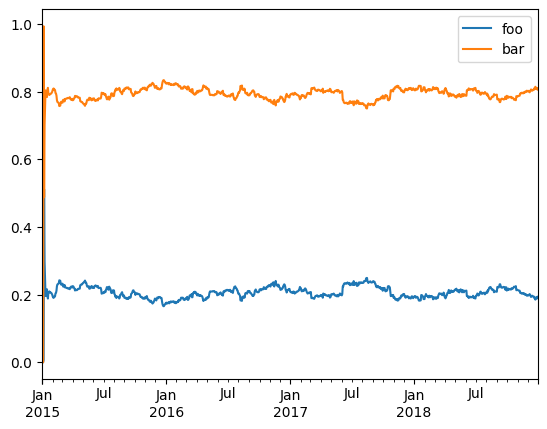

In [6]:
res_target.get_security_weights().plot();

Now use the PTE rebalance algo to trigger a rebalance whenever predicted tracking error is greater than 1%.

In [13]:
# algo to fire whenever predicted tracking error is greater than 1%
# 1. 获取之前策略的资产权重：
#    这行代码从之前运行的回测res_target中获取每个时间点上每个资产的权重，并将其存储在wdf中。
wdf = res_target.get_security_weights()
# 2. 定义预测跟踪误差再平衡算法：
#    这个算法会在预测的跟踪误差（PTE）超过1%时触发再平衡。跟踪误差是指组合收益与基准收益之间的差异。
#    该算法使用过去三个月的数据（排除最近一天）来预测跟踪误差，使用标准方法计算协方差，并以252天作为年化因子。
PTE_rebalance_Algo = bt.algos.PTE_Rebalance(
    0.01,
    wdf,
    lookback=pd.DateOffset(months=3),
    lag=pd.DateOffset(days=1),
    covar_method='standard',
    annualization_factor=252
)
# 3. 选择特定资产：
#    再次使用这个算法，确保策略只针对foo和bar两个资产。
selectTheseAlgo = bt.algos.SelectThese(['foo','bar'])

# algo to set the weights to 1/vol contributions from each asset
#  with data over the last 12 months excluding yesterday
# 4. 设置目标权重算法：
#    这个算法根据wdf中提供的权重信息设置目标权重。这意味着策略将尝试保持资产的权重与wdf中指定的目标权重相匹配。
weighTargetAlgo = bt.algos.WeighTarget(
    wdf
)

# 5. 再平衡算法：
#    与之前类似，这个算法将根据目标权重调整资产配置，以确保组合的实际权重与目标权重一致。
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy(
    'PTE',
    [
        PTE_rebalance_Algo,
        selectTheseAlgo,
        weighTargetAlgo,
        rebalAlgo
    ]
)

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    pdf,
    integer_positions=False
)

res_PTE = bt.run(backtest)

这段代码主要进行了以下几个步骤的操作，旨在对比和分析两个投资策略（目标策略和预测跟踪误差策略，即PTE策略）的表现：

### 1. 绘制目标权重与PTE权重的对比图
- 首先，使用`matplotlib`库创建一个绘图区域，并绘制目标策略的安全资产权重。
- 然后，修改PTE策略中的`foo`和`bar`资产权重列名，仅保留这两个资产的权重数据，并在同一图表上绘制出来。
- 通过设置图表标题为"Target Weights vs PTE Weights"，明确表示这是一个目标权重与PTE权重的对比图。

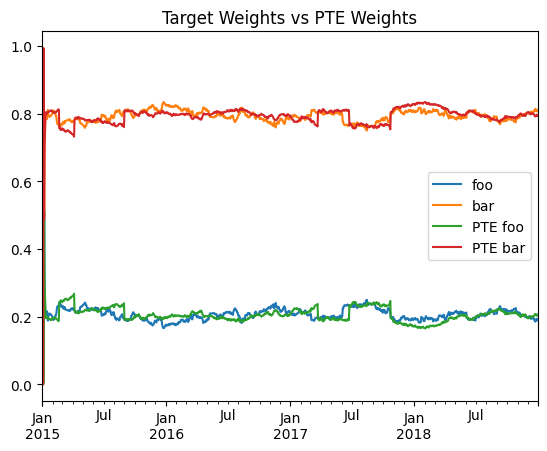

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1)
res_target.get_security_weights().plot(ax=ax)

realized_weights_df = res_PTE.get_security_weights()
realized_weights_df['PTE foo'] = realized_weights_df['foo']
realized_weights_df['PTE bar'] = realized_weights_df['bar']
realized_weights_df = realized_weights_df.loc[:,['PTE foo', 'PTE bar']]
realized_weights_df.plot(ax=ax)

ax.set_title('Target Weights vs PTE Weights')
ax.plot();

策略一和策略二在本质上有相似之处，但也存在关键的不同。这两种策略都使用了相同的资产（`foo`和`bar`），并且都采用了动态再平衡的方法，但它们的再平衡触发条件和权重分配逻辑不同。

### 策略一的核心：
- **选择资产**：选定`foo`和`bar`作为投资组合的资产。
- **权重分配**：通过`WeighInvVol`算法基于过去三个月的波动率来动态分配资产权重，其中使用了一天的滞后期。这意味着策略会倾向于向波动性较低的资产分配更多的权重。
- **再平衡**：每天根据`WeighInvVol`算法计算出的新权重进行再平衡。

### 策略二的核心：
- **权重获取**：从策略一的结果中获取历史权重数据，用作目标权重。
- **预测跟踪误差再平衡**（PTE_rebalance）：当预测的跟踪误差超过1%时触发再平衡。这是通过比较当前权重与策略一中获得的历史权重来评估的。
- **目标权重分配**：使用`WeighTarget`算法直接将目标权重分配给资产，这些目标权重来自策略一。
- **再平衡**：根据PTE_rebalance算法和权重分配算法的结果进行再平衡。

### 关系与区别：
- **关系**：策略二在某种程度上依赖于策略一的结果。它使用策略一生成的权重作为目标权重，并在这个基础上应用预测跟踪误差再平衡算法。
- **区别**：
  - **再平衡触发条件**：策略一是基于时间周期（每天）自动再平衡，而策略二是基于预测跟踪误差超过特定阈值时触发再平衡。
  - **权重分配逻辑**：策略一通过反向波动率分配权重，而策略二则采用固定的目标权重，这些目标权重是从策略一的运行结果中获得的。

因此，可以说策略二并非对策略一的简单复刻，而是在策略一的基础上引入了基于预测跟踪误差的动态再平衡机制，使得两者在执行逻辑上存在明显差异。

### 2. 计算并绘制累积交易额
- 创建一个新的DataFrame（`trans_df`），用于存放每个策略的累积交易额。
- 从目标策略和PTE策略中提取交易数据，计算每个策略的交易额（通过交易数量乘以价格），并按照`foo`和`bar`资产分别进行筛选。
- 将计算得到的交易额累积值绘制在图表上，并设置图表标题为"Cumulative sum of notional traded"，展示了随时间累积的交易额。

In [37]:
trans_df = pd.DataFrame(
    index=res_target.prices.index,
    columns=['Target','PTE']
)

transactions = res_target.get_transactions()

In [38]:
transactions

price      quantity
Date       Security                          
2015-01-06 bar        99.309091  10004.778160
           foo        99.384330     64.744331
2015-01-07 bar        99.692444  -5089.862875
           foo       100.507366   5048.593814
2015-01-08 bar       100.208933   2031.400484
...                         ...           ...
2018-12-27 foo       218.025463     14.521404
2018-12-28 bar       126.838740     37.797629
           foo       219.766321    -21.815006
2018-12-31 bar       126.362930    -33.310863
           foo       221.184894     19.030496

[2080 rows x 2 columns]

In [31]:
transactions = (transactions['quantity'] * transactions['price']).reset_index()

bar_mask = transactions.loc[:,'Security'] == 'bar'
foo_mask = transactions.loc[:,'Security'] == 'foo'

trans_df.loc[trans_df.index[4:],'Target'] = np.abs(transactions[bar_mask].iloc[:,2].values) + np.abs(transactions[foo_mask].iloc[:,2].values)

In [32]:
transactions = res_PTE.get_transactions()
transactions = (transactions['quantity'] * transactions['price']).reset_index()

bar_mask = transactions.loc[:,'Security'] == 'bar'
foo_mask = transactions.loc[:,'Security'] == 'foo'

trans_df.loc[transactions[bar_mask].iloc[:,0],'PTE'] =  np.abs(transactions[bar_mask].iloc[:,2].values)
trans_df.loc[transactions[foo_mask].iloc[:,0],'PTE'] +=  np.abs(transactions[foo_mask].iloc[:,2].values)

In [33]:
trans_df

,Target,PTE
2014-12-31,NaN,NaN
2015-01-01,NaN,NaN
2015-01-02,NaN,NaN
2015-01-05,NaN,NaN
2015-01-06,1000000.0,1000000.0
...,...,...
2018-12-25,9725.529158,NaN
2018-12-26,13776.894785,NaN
2018-12-27,6332.07183,NaN
2018-12-28,9588.407205,NaN


In [29]:
trans_df = trans_df.fillna(0)

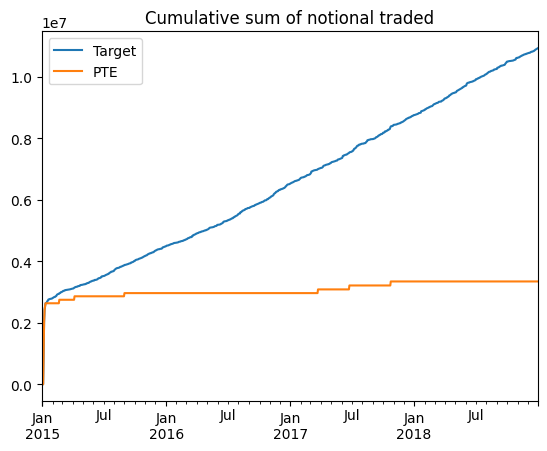

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=1)
trans_df.cumsum().plot(ax=ax)
ax.set_title('Cumulative sum of notional traded')
ax.plot();

### 3. 计算并绘制总风险贡献对比
- 计算目标策略和PTE策略的滚动协方差矩阵，用于后续的总风险贡献（TRC）计算。
- 使用滚动协方差矩阵和各自策略的权重，计算每个策略在每个时间点的总风险贡献，并将这些数据绘制在图表中。
- 图表标题设置为"Total Risk Contribution"，旨在展示两种策略在不同时间点上的总风险贡献对比。

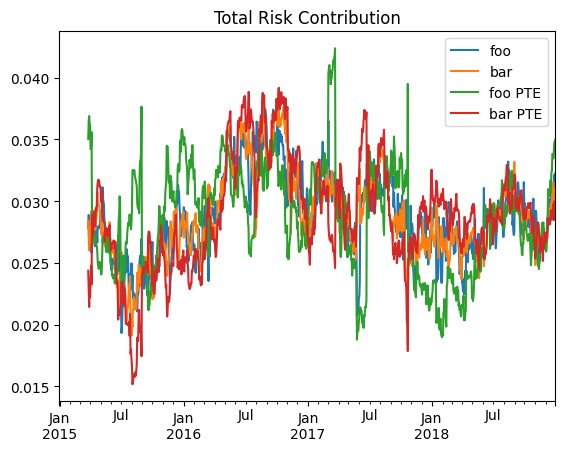

In [20]:
weights_target = res_target.get_security_weights()
rolling_cov_target = pdf.loc[:,weights_target.columns].pct_change().rolling(window=3*20).cov()*252

weights_PTE = res_PTE.get_security_weights().loc[:,weights_target.columns]
rolling_cov_PTE = pdf.loc[:,weights_target.columns].pct_change().rolling(window=3*20).cov()*252


trc_target = pd.DataFrame(
    np.nan,
    index = weights_target.index,
    columns = weights_target.columns
)

trc_PTE = pd.DataFrame(
    np.nan,
    index = weights_PTE.index,
    columns = [x + " PTE" for x in weights_PTE.columns]
)

for dt in pdf.index:
    trc_target.loc[dt,:] = weights_target.loc[dt,:].values*(rolling_cov_target.loc[dt,:].values@weights_target.loc[dt,:].values)/np.sqrt(weights_target.loc[dt,:].values@rolling_cov_target.loc[dt,:].values@weights_target.loc[dt,:].values)
    trc_PTE.loc[dt,:] = weights_PTE.loc[dt,:].values*(rolling_cov_PTE.loc[dt,:].values@weights_PTE.loc[dt,:].values)/np.sqrt(weights_PTE.loc[dt,:].values@rolling_cov_PTE.loc[dt,:].values@weights_PTE.loc[dt,:].values)


fig, ax = plt.subplots(nrows=1,ncols=1)
trc_target.plot(ax=ax)
trc_PTE.plot(ax=ax)
ax.set_title('Total Risk Contribution')
ax.plot();

In [ ]:
### 4. 绘制总风险对比图
- 计算并绘制两种策略的总风险（即所有资产风险贡献的总和）随时间的变化。
- 图表中还包括了一个图例，以区分目标策略和PTE策略的总风险线。

### 5. 标记PTE策略交易发生日期
- 提取PTE策略中`bar`资产的交易日期，并在总风险对比图上以红线标记这些日期。
- 这一步骤旨在直观展示PTE策略进行交易调整的时间点，以及这些调整与总风险之间的关系。

总之，这段代码通过数据处理、计算和可视化的方式，深入分析了目标策略与PTE策略在权重分配、交易额、总风险贡献等多个方面的差异和联系。通过这些对比分析，可以更好地理解每种策略的特点及其在实际应用中的表现。